# Battle of the Bands: generic data analysis<a name="top"></a>

This does the analysis of the band data, once it's [been gathered](multi-artist-gather-data.ipynb). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import urllib.request
import urllib.parse
import urllib.error
import json
import base64
import configparser
from bs4 import BeautifulSoup
import re
import pymongo
from datetime import datetime
import time
import collections
import editdistance
import math
from scipy.spatial import ConvexHull
from pandas.plotting import scatter_matrix

We'll use MongoDB to store the data, to save keeping it all in memory, and mean we don't have to recapture all the data to to a different analysis.

In [2]:
# Open a connection to the Mongo server
client = pymongo.MongoClient('mongodb://localhost:27017/')

In [3]:
# Create a database and a collections within it.
songs_db = client.songs
albums = songs_db.albums
unfiltered_tracks = songs_db.tracks
genius_tracks = songs_db.gtracks

In [4]:
unfiltered_tracks.update_many({'gloom': {'$exists': True}}, {'$unset': {'gloom': ''}})
unfiltered_tracks.update_many({'complexity': {'$exists': True}}, {'$unset': {'complexity': ''}})

In [6]:
songs_db.collection_names()

['system.views',
 'gtracks',
 'system.indexes',
 'sentiments',
 'albums',
 'tracks',
 'interesting_tracks']

In [7]:
interesting_pipe = [{'$match':{'ignore': {'$exists': False}}}]
if 'interesting_tracks' not in songs_db.collection_names():
    songs_db.command("create", "interesting_tracks",
        viewOn='tracks', 
        pipeline=interesting_pipe)

In [8]:
tracks = songs_db.interesting_tracks

API keys and the like are kept in a configuration file, which is read here.

You'll need to create a web API key for Spotify and Genius. 

In [9]:
config = configparser.ConfigParser()
config.read('secrets.ini')
[k for k in config['genius']]

['app_name', 'client_id', 'client_secret', 'redirect_uri', 'token']

In [57]:
artist_ids = { 'The Rolling Stones': '22bE4uQ6baNwSHPVcDxLCe'
             , 'The Beatles': '3WrFJ7ztbogyGnTHbHJFl2'
             , 'Radiohead': '4Z8W4fKeB5YxbusRsdQVPb'
             , 'Spice Girls': '0uq5PttqEjj3IH1bzwcrXF'
             , 'Abba': '0LcJLqbBmaGUft1e9Mm8HV'
             , 'Foo Fighters': '7jy3rLJdDQY21OgRLCZ9sD'
             , 'Led Zeppelin': '36QJpDe2go2KgaRleHCDTp'
             , 'Queen' : '1dfeR4HaWDbWqFHLkxsg1d'
             }

In [11]:
# radiohead_id = albums.find_one({'artist_name': 'Radiohead'})['artist_id']
# radiohead_id

## Which values to analyse?

Find all the possible scores and pull them into a dataframe.

In [14]:
tracks.find_one().keys()

dict_keys(['artist_name', 'original_lyrics', 'instrumentalness', 'explicit', 'mode', 'tempo', 'acousticness', 'duration_ms', 'liveness', 'preview_url', 'analysis_url', 'available_markets', 'href', 'album_id', 'track_number', 'lyrical_density', 'disc_number', 'name', 'album', 'artists', 'time_signature', 'energy', 'id', '_id', 'key', 'uri', 'speechiness', 'popularity', 'external_ids', 'artist_id', 'danceability', 'external_urls', 'track_href', 'type', 'loudness', 'ctitle', 'valence'])

In [15]:
numeric_keys = ['popularity', 'instrumentalness', 'speechiness', 'tempo', 
                'danceability', 'acousticness', 'loudness', 'time_signature', 
                'lyrical_density', 'valence', 'liveness', 'energy', 'key']
# 'explicit', # complexity, # gloom

projection_dict = {k: '$' + k for k in numeric_keys}
projection_dict.update({'neg': '$sentiment.probability.neg',
                        'pos': '$sentiment.probability.pos',                        
                        'nnrc_fear': '$nnrc_sentiment.fear',
                        'nnrc_trust': '$nnrc_sentiment.trust',
                        'nnrc_surprise': '$nnrc_sentiment.surprise',
                        'nnrc_anticipation': '$nnrc_sentiment.anticipation',
                        'nnrc_sadness': '$nnrc_sentiment.sadness',
                        'nnrc_joy': '$nnrc_sentiment.joy',
                        'nnrc_positive': '$nnrc_sentiment.positive',
                        'nnrc_disgust': '$nnrc_sentiment.disgust',
                        'nnrc_anger': '$nnrc_sentiment.anger',
                        'nnrc_negative': '$nnrc_sentiment.negative',
                        'popularity0': {'$literal': 0},
                        '_id': 0})
projection_dict

{'_id': 0,
 'acousticness': '$acousticness',
 'danceability': '$danceability',
 'energy': '$energy',
 'instrumentalness': '$instrumentalness',
 'key': '$key',
 'liveness': '$liveness',
 'loudness': '$loudness',
 'lyrical_density': '$lyrical_density',
 'neg': '$sentiment.probability.neg',
 'nnrc_anger': '$nnrc_sentiment.anger',
 'nnrc_anticipation': '$nnrc_sentiment.anticipation',
 'nnrc_disgust': '$nnrc_sentiment.disgust',
 'nnrc_fear': '$nnrc_sentiment.fear',
 'nnrc_joy': '$nnrc_sentiment.joy',
 'nnrc_negative': '$nnrc_sentiment.negative',
 'nnrc_positive': '$nnrc_sentiment.positive',
 'nnrc_sadness': '$nnrc_sentiment.sadness',
 'nnrc_surprise': '$nnrc_sentiment.surprise',
 'nnrc_trust': '$nnrc_sentiment.trust',
 'popularity': '$popularity',
 'popularity0': {'$literal': 0},
 'pos': '$sentiment.probability.pos',
 'speechiness': '$speechiness',
 'tempo': '$tempo',
 'time_signature': '$time_signature',
 'valence': '$valence'}

In [16]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True}}},
    {'$project': projection_dict}
]
all_pre_raw_df = pd.DataFrame(list(tracks.aggregate(pipeline)))

In [17]:
all_pre_raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,1274.0,0.247955,0.263212,0.000002,0.023900,0.145500,0.394000,0.968000
danceability,1274.0,0.474683,0.156753,0.000000,0.359250,0.472000,0.583000,0.933000
energy,1274.0,0.692222,0.218528,0.016500,0.533000,0.730000,0.878750,0.999000
instrumentalness,1274.0,0.104411,0.231855,0.000000,0.000008,0.000550,0.044150,0.999000
key,1274.0,4.928571,3.495986,0.000000,2.000000,5.000000,8.000000,11.000000
liveness,1274.0,0.284202,0.259244,0.000000,0.102000,0.172000,0.359000,0.990000
loudness,1274.0,-7.985659,2.905025,-23.459000,-9.788750,-7.731500,-5.871250,-1.429000
lyrical_density,1274.0,0.915163,0.418726,0.003815,0.627443,0.869566,1.140101,2.889722
neg,1274.0,0.618922,0.171887,0.101905,0.506820,0.624937,0.768355,0.904388
nnrc_anger,1005.0,0.311544,0.228523,0.012821,0.142857,0.250000,0.423077,1.000000


Now we have the ranges, move them all into the range 0-1, remembering the scaling for future use.

In [18]:
all_pre_df=(all_pre_raw_df-all_pre_raw_df.min())/(all_pre_raw_df.max()-all_pre_raw_df.min())
all_pre_df.popularity0 = 0
all_pre_df.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,1274.0,0.256150,0.271914,0.0,0.024688,0.150308,0.407023,1.0
danceability,1274.0,0.508771,0.168009,0.0,0.385048,0.505895,0.624866,1.0
energy,1274.0,0.687757,0.222420,0.0,0.525700,0.726209,0.877608,1.0
instrumentalness,1274.0,0.104516,0.232087,0.0,0.000008,0.000551,0.044194,1.0
key,1274.0,0.448052,0.317817,0.0,0.181818,0.454545,0.727273,1.0
liveness,1274.0,0.287073,0.261862,0.0,0.103030,0.173737,0.362626,1.0
loudness,1274.0,0.702376,0.131867,0.0,0.620529,0.713913,0.798355,1.0
lyrical_density,1274.0,0.315792,0.145093,0.0,0.216094,0.299993,0.393736,1.0
neg,1274.0,0.644272,0.214194,0.0,0.504578,0.651767,0.830485,1.0
nnrc_anger,1005.0,0.302603,0.231491,0.0,0.131725,0.240260,0.415584,1.0


In [19]:
all_pre_df

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,lyrical_density,neg,nnrc_anger,...,nnrc_sadness,nnrc_surprise,nnrc_trust,popularity,popularity0,pos,speechiness,tempo,time_signature,valence
0,0.439048,0.848875,0.759796,0.627628,0.181818,0.796970,0.557149,0.057550,0.360472,NaN,...,NaN,NaN,NaN,0.564103,0,0.639528,0.106526,0.425867,0.8,0.155738
1,0.140494,0.554126,0.594911,0.834835,0.181818,0.120202,0.608488,0.007807,0.622129,NaN,...,NaN,NaN,NaN,0.397436,0,0.377871,0.086947,0.335331,0.8,0.760246
2,0.711776,0.248660,0.482952,0.938939,0.090909,0.066869,0.732229,0.006360,0.537797,NaN,...,NaN,NaN,NaN,0.435897,0,0.462203,0.069263,0.329760,0.6,0.156762
3,0.065907,0.435155,0.696692,0.896897,0.363636,0.231313,0.780844,0.000207,0.537797,NaN,...,NaN,NaN,NaN,0.346154,0,0.462203,0.063368,0.739918,0.8,0.478484
4,0.869834,0.364416,0.320102,0.833834,0.000000,0.113131,0.254290,0.007784,0.687087,NaN,...,NaN,NaN,NaN,0.576923,0,0.312913,0.068421,0.671074,0.8,0.682377
5,0.220039,0.311897,0.975573,0.908909,0.545455,0.335354,0.576714,0.000000,0.537797,NaN,...,NaN,NaN,NaN,0.435897,0,0.462203,0.117263,0.854050,0.8,0.130123
6,0.220039,0.311897,0.975573,0.908909,0.545455,0.335354,0.576714,0.000000,0.537797,NaN,...,NaN,NaN,NaN,0.410256,0,0.462203,0.117263,0.854050,0.8,0.130123
7,0.146692,0.000000,0.000000,1.000000,0.909091,0.000000,0.368634,0.083879,0.504531,NaN,...,NaN,NaN,NaN,0.000000,0,0.495469,0.000000,0.000000,0.0,0.000000
8,0.523759,0.622722,0.818830,0.000000,0.000000,0.109091,0.865729,0.365594,0.532734,NaN,...,NaN,0.155844,0.140625,0.692308,0,0.467266,0.066947,0.644934,0.8,0.991803
9,0.268593,0.404073,0.915522,0.000000,0.363636,0.074747,0.919655,0.556854,0.536918,0.366883,...,0.620130,NaN,0.097656,0.743590,0,0.463082,0.101263,0.357808,0.8,0.934426


## Columns to drop
Find the covariances of the different metrics, and use that to drop the columns with the highest covariances. 

In [21]:
adc = all_pre_df.drop(['popularity0'], axis=1).cov().stack().abs().sort_values()
adc[adc.index.get_level_values(0) < adc.index.get_level_values(1)]

nnrc_positive      speechiness          0.000007
key                time_signature       0.000020
lyrical_density    neg                  0.000029
                   pos                  0.000029
danceability       nnrc_anger           0.000056
lyrical_density    tempo                0.000064
                   popularity           0.000105
nnrc_trust         speechiness          0.000106
tempo              time_signature       0.000118
key                lyrical_density      0.000121
neg                time_signature       0.000125
pos                time_signature       0.000125
popularity         time_signature       0.000177
instrumentalness   key                  0.000184
pos                speechiness          0.000223
neg                speechiness          0.000223
danceability       loudness             0.000223
nnrc_sadness       time_signature       0.000224
nnrc_fear          speechiness          0.000230
nnrc_anticipation  tempo                0.000233
nnrc_surprise      v

In [22]:
columns_to_drop = ['popularity0', 'nnrc_positive', 'nnrc_negative', 
                   'pos', 'neg', 'energy',
                   'time_signature', 'speechiness', 'instrumentalness', 'liveness',
                  'popularity', 'loudness', 'lyrical_density']

In [23]:
adc = all_pre_df.drop(columns_to_drop, axis=1).cov().stack().abs().sort_values()
adc[adc.index.get_level_values(0) < adc.index.get_level_values(1)]

danceability       nnrc_anger           0.000056
nnrc_anticipation  tempo                0.000233
nnrc_surprise      valence              0.000275
danceability       nnrc_trust           0.000310
key                nnrc_surprise        0.000311
danceability       nnrc_disgust         0.000340
nnrc_anger         nnrc_anticipation    0.000430
danceability       nnrc_fear            0.000506
                   nnrc_surprise        0.000510
key                nnrc_disgust         0.000525
nnrc_anger         tempo                0.000574
nnrc_trust         tempo                0.000600
nnrc_sadness       tempo                0.000880
nnrc_disgust       tempo                0.000897
key                nnrc_fear            0.000939
                   tempo                0.001029
                   valence              0.001139
acousticness       nnrc_trust           0.001177
danceability       key                  0.001214
key                nnrc_anticipation    0.001242
acousticness       n

In [24]:
pipeline = [
    {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True}}},
    {'$project': projection_dict}
]
all_raw_df = pd.DataFrame(list(tracks.aggregate(pipeline)))
all_raw_df.drop(columns_to_drop, axis=1, inplace=True)

all_df=(all_raw_df-all_raw_df.min())/(all_raw_df.max()-all_raw_df.min())
all_df.popularity0 = 0
all_df.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,1274.0,0.256150,0.271914,0.0,0.024688,0.150308,0.407023,1.0
danceability,1274.0,0.508771,0.168009,0.0,0.385048,0.505895,0.624866,1.0
key,1274.0,0.448052,0.317817,0.0,0.181818,0.454545,0.727273,1.0
nnrc_anger,1005.0,0.302603,0.231491,0.0,0.131725,0.240260,0.415584,1.0
nnrc_anticipation,1147.0,0.462675,0.288016,0.0,0.225000,0.425926,0.655556,1.0
nnrc_disgust,886.0,0.269933,0.225152,0.0,0.106188,0.189610,0.376623,1.0
nnrc_fear,1082.0,0.364779,0.270597,0.0,0.138961,0.298701,0.493506,1.0
nnrc_joy,1186.0,0.571578,0.293277,0.0,0.308642,0.601140,0.827160,1.0
nnrc_sadness,1082.0,0.393688,0.265499,0.0,0.189610,0.324675,0.565863,1.0
nnrc_surprise,994.0,0.283297,0.211339,0.0,0.122078,0.228200,0.400990,1.0


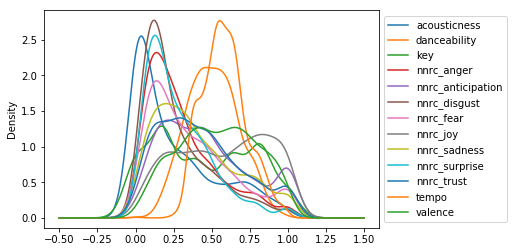

In [25]:
ax = all_df.plot.kde()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

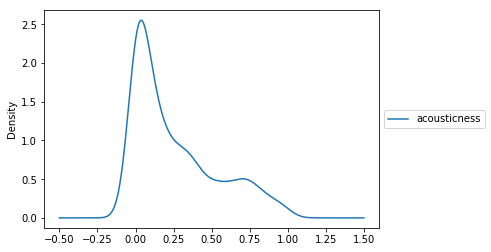

In [26]:
ax = all_df[['acousticness']].plot.kde()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [27]:
all_df

,acousticness,danceability,key,nnrc_anger,nnrc_anticipation,nnrc_disgust,nnrc_fear,nnrc_joy,nnrc_sadness,nnrc_surprise,nnrc_trust,tempo,valence
0,0.439048,0.848875,0.181818,NaN,NaN,NaN,NaN,0.222222,NaN,NaN,NaN,0.425867,0.155738
1,0.140494,0.554126,0.181818,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.335331,0.760246
2,0.711776,0.248660,0.090909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.329760,0.156762
3,0.065907,0.435155,0.363636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.739918,0.478484
4,0.869834,0.364416,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.671074,0.682377
5,0.220039,0.311897,0.545455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.854050,0.130123
6,0.220039,0.311897,0.545455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.854050,0.130123
7,0.146692,0.000000,0.909091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
8,0.523759,0.622722,0.000000,NaN,0.483333,NaN,NaN,1.000000,NaN,0.155844,0.140625,0.644934,0.991803
9,0.268593,0.404073,0.363636,0.366883,0.354167,0.176948,0.366883,0.805556,0.620130,NaN,0.097656,0.357808,0.934426


## Analysis and calculation of the convex hull

`artist_features()` extract the data for one artist and scales the various scores according to the `all_raw_df` values.

`convex_hull_volume()` does the actual calculation. The shuffling is done determinsitically (with a fixed random seed) to make the calculations repeatable.

In [28]:
def artist_features(artist_id):

    pipeline = [
        {'$match': {'lyrics': {'$exists': True}, 'sentiment': {'$exists': True}, 'valence': {'$exists': True},
                   'artist_id': artist_id}},
        {'$project': projection_dict}
    ]
    raw_df = pd.DataFrame(list(tracks.aggregate(pipeline)))
    raw_df.drop(columns_to_drop, axis=1, inplace=True)
    raw_df.fillna(0, inplace=True)
    df = (raw_df-all_raw_df.min()) / (all_raw_df.max()-all_raw_df.min())
    df.popularity0 = 0
    return df

In [29]:
def convex_hull_volume(artist_df, state=42, groups=4):
    artist_s_df = artist_df.sample(frac=1, random_state=state)
    rows_per_subframe = math.ceil(len(artist_s_df) / groups)
    subframes = [i[1] for i in artist_s_df.groupby(np.arange(len(artist_s_df))//rows_per_subframe)]
    total_vol = 0
    for subframe in subframes:
        sub_ar = subframe.as_matrix()
        hull = ConvexHull(sub_ar, qhull_options='QJ')
        total_vol += hull.volume
    return total_vol

In [30]:
# sub_ar = subframes[0].as_matrix()
# hull = ConvexHull(sub_ar, qhull_options='QJ')
# hull.volume

In [31]:
beatles_df = artist_features(artist_ids['The Beatles'])
beatles_df

,acousticness,danceability,key,nnrc_anger,nnrc_anticipation,nnrc_disgust,nnrc_fear,nnrc_joy,nnrc_sadness,nnrc_surprise,nnrc_trust,tempo,valence
0,0.439048,0.848875,0.181818,-0.012987,-0.033333,-0.012987,-0.012987,0.222222,-0.012987,-0.012987,-0.031250,0.425867,0.155738
1,0.523759,0.622722,0.000000,-0.012987,0.483333,-0.012987,-0.012987,1.000000,-0.012987,0.155844,0.140625,0.644934,0.991803
2,0.268593,0.404073,0.363636,0.366883,0.354167,0.176948,0.366883,0.805556,0.620130,-0.012987,0.097656,0.357808,0.934426
3,0.398759,0.525188,0.636364,-0.012987,0.311111,-0.012987,1.000000,0.654321,-0.012987,-0.012987,0.312500,0.619264,0.887295
4,0.093386,0.604502,0.636364,-0.012987,0.452941,-0.012987,-0.012987,1.000000,-0.012987,0.046600,0.090074,0.425615,0.934426
5,0.123965,0.712755,0.545455,-0.012987,0.704762,-0.012987,-0.012987,0.703704,-0.012987,0.276438,0.705357,0.651131,0.748975
6,0.065597,0.405145,0.181818,0.392208,1.000000,-0.012987,0.088312,0.377778,0.189610,0.290909,0.278125,0.502470,0.663934
7,0.151857,0.505895,0.636364,-0.012987,0.046154,0.064935,0.025974,-0.037037,-0.012987,0.064935,0.048077,0.372792,0.861680
8,0.145659,0.696677,0.181818,0.263282,0.436364,0.079103,-0.012987,0.528620,0.079103,0.171192,0.625000,0.519226,0.588115
9,0.011568,0.413719,0.909091,0.392208,0.380000,0.594805,0.797403,0.170370,0.594805,-0.012987,0.381250,0.697336,0.545082


In [32]:
beatles_volume = convex_hull_volume(beatles_df)
beatles_volume

2.113885406456015e-06

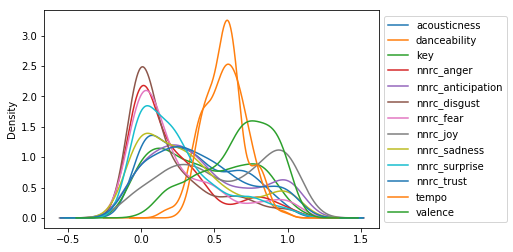

In [69]:
# ax = beatles_df.drop(['popularity0'], axis=1).plot.kde()
ax = beatles_df.plot.kde()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [70]:
# ax = stones_df.plot.kde()
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [33]:
beatles_df.columns.size

13

### Do the calculation
This cycles through all the known artist IDs and calculates the convex hull volume for each.

Note the couple of special cases: there are so few Spice Girls tracks, we can't split them into four sections. The Queen analysis blows up the convex hull calculation when `state=42`.

In [76]:
results_df = pd.DataFrame([{'name': k, 'id': artist_ids[k]}
                          for k in artist_ids])
results_df.set_index('id', inplace=True)
results_df['raw_volume'] = 0

artist_scores = {}

for artist in artist_ids:
    print('starting', artist)
    artist_df = artist_features(artist_ids[artist])
    if artist == 'Spice Girls':
        artist_volume = convex_hull_volume(artist_df, groups=1, state=77777) * 4
    elif artist == 'Queen':
        artist_volume = convex_hull_volume(artist_df, groups=4, state=77777)
    else:
        artist_volume = convex_hull_volume(artist_df, state=77777)
    artist_scores[artist] = artist_volume
    print(artist, artist_volume)


starting Radiohead
Radiohead 1.3735907773308412e-08
starting Foo Fighters
Foo Fighters 7.666641146914435e-09
starting Spice Girls
Spice Girls 2.5497245489351534e-09
starting Led Zeppelin
Led Zeppelin 7.120684861152149e-09
starting Queen
Queen 7.675230324648466e-07
starting The Beatles
The Beatles 1.8584109644151603e-06
starting The Rolling Stones
The Rolling Stones 1.3830666327684997e-06
starting Abba
Abba 3.986374918574468e-09


In [77]:
# seed_artist_scores = {}
seed_artist_scores[77777] = {k: v for k, v in artist_scores.items()}
seed_artist_scores

{42: {'Abba': 5.682966002661997e-09,
  'Foo Fighters': 1.6874480985875627e-08,
  'Led Zeppelin': 1.0078024641849407e-08,
  'Queen': 7.149182754285038e-07,
  'Radiohead': 1.6984954630731168e-08,
  'Spice Girls': 2.5497245468497206e-09,
  'The Beatles': 2.113885406456015e-06,
  'The Rolling Stones': 1.389105641110557e-06},
 123: {'Abba': 2.7090200835856255e-09,
  'Foo Fighters': 1.2874782699947662e-08,
  'Led Zeppelin': 6.8943416946745336e-09,
  'Queen': 7.149182754285038e-07,
  'Radiohead': 1.3597240666142407e-08,
  'Spice Girls': 2.5497245457016713e-09,
  'The Beatles': 2.276084073574721e-06,
  'The Rolling Stones': 1.2714625609036554e-06},
 999: {'Abba': 3.609183347846526e-09,
  'Foo Fighters': 1.3255723616195349e-08,
  'Led Zeppelin': 6.9007454600734344e-09,
  'Queen': 8.411696372118656e-07,
  'Radiohead': 1.3715723194819635e-08,
  'Spice Girls': 2.5497245472409113e-09,
  'The Beatles': 1.6188840757436778e-06,
  'The Rolling Stones': 1.2579221200636931e-06},
 77777: {'Abba': 3.986374

In [70]:
sorted(((k, math.pow(s, 1/13) * 1000) for k, s in artist_scores.items()), key=lambda p: p[1])

[('Spice Girls', 218.25340121957652),
 ('Abba', 224.1660910874002),
 ('Led Zeppelin', 235.62576082803054),
 ('Foo Fighters', 247.7599095937317),
 ('Radiohead', 248.41091249485208),
 ('Queen', 340.9442362055484),
 ('The Rolling Stones', 351.6634333304922),
 ('The Beatles', 358.5544012084572)]

In [78]:
math.pow(artist_scores['The Beatles'], 1/13) / math.pow(artist_scores['The Rolling Stones'], 1/13)

1.0229846740306523

In [79]:
s = 123
math.pow(seed_artist_scores[s]['The Beatles'], 1/13) / math.pow(seed_artist_scores[s]['The Rolling Stones'], 1/13)

1.0458097129614543

In [36]:
# original_artist_scores = artist_scores
original_artist_scores

{'Abba': 5.682966002661997e-09,
 'Foo Fighters': 1.6874480985875627e-08,
 'Led Zeppelin': 1.0078024641849407e-08,
 'Radiohead': 1.6984954630731168e-08,
 'Spice Girls': 2.5497245468497206e-09,
 'The Beatles': 2.113885406456015e-06,
 'The Rolling Stones': 1.389105641110557e-06}

In [52]:
math.pow(7.149182754285038e-07, 1/13) * 1000, math.pow(8.411696372118656e-07, 1/13) * 1000

(336.7057183984806, 340.9442362055484)

In [55]:
365.98880658455073 / 354.35712950833306

1.0328247299337718